In [1]:
from BLOCH_beamline import *

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

---- BLOCH beamline ----
	Last updated 02.12.2018 

	Latest change: M1 pitch lookup



In [22]:
# Since we can't just slurp up all scans in all files, we will semi-manually compile a list of good scans to use

#*****************************************************
def addScansToList(scanList,path,targetLength):
#*****************************************************

    h5_fp=loadHDF5(path)
    scanNames = [key.lstrip('entry') for key in h5_fp.keys()]
    for scanName in scanNames:

        dataSetNames = [key for key in h5_fp["entry{0}/measurement".format(scanName)].keys()]
        dataSetLength = len(np.array(h5_fp["entry{0}/measurement/{1}".format(scanName,dataSetNames[0])]))

        if dataSetLength == targetLength:
            scanList.append((path,scanName))

    h5_fp.close()
    
#*****************************************************
def removeScanFromList(scanList,scanName):
#*****************************************************
    for scan in scanList:
        if scan[1]==scanName:
            scanList.remove(scan)
    return scanList

# EPU gap and phase info is not always saved. If you check for it, you can add that info to the plots   

#*****************************************************
def EPU_info_exists(fileName,scanIndex):
#*****************************************************    
    h5_fp=loadHDF5(fileName)
    dataSetNames = [key for key in h5_fp["entry{0}/measurement".format(scanIndex)].keys()]
    h5_fp.close()
    if ('EPU_R1_110_GAPposition' in dataSetNames) and ('EPU_R1_110_PHASEposition' in dataSetNames):
        return 1
    else:
        return 0
    
#*****************************************************
def valuesAreClose(val1,val2):
#*****************************************************    
    if abs(val1-val2)/abs(val1+val2) < 0.01:
        return 1
    else:
        return 0

In [23]:
HDF5info('Data/(18.12.16)VP_monobaf4x4_2.h5')
HDF5info('Data/(18.12.16)VP_monobaf4x4_2B.h5')
HDF5info('Data/(18.12.16)VP_monobaf4x4_2C.h5')
HDF5info('Data/(18.12.16)VP_monobaf4x4_2D.h5')


Data/(18.12.16)VP_monobaf4x4_2.h5 contains 2 scans:
(I am stripping off the 'entry' part of their name)


Scan index	 # datasets 	 # points in first dataset
----------------------------------------------------------
6116		12		18
6117		12		181

Data/(18.12.16)VP_monobaf4x4_2B.h5 contains 6 scans:
(I am stripping off the 'entry' part of their name)


Scan index	 # datasets 	 # points in first dataset
----------------------------------------------------------
6118		12		121
6119		12		121
6120		12		121
6121		12		121
6122		12		121
6123		12		121

Data/(18.12.16)VP_monobaf4x4_2C.h5 contains 15 scans:
(I am stripping off the 'entry' part of their name)


Scan index	 # datasets 	 # points in first dataset
----------------------------------------------------------
6124		12		126
6125		12		126
6126		12		126
6127		12		126
6128		12		126
6129		12		126
6130		12		126
6131		12		126
6132		12		121
6133		12		121
6134		12		121
6135		12		101
6136		12		101
6137		12		101
6138		12		0

Data/(18.12.16)VP_monobaf4

In [24]:
HDF5scaninfo('Data/(18.12.16)VP_monobaf4x4_2.h5',6117)

entry6117 contains 12 datasets:

	 EPU_R1_110_GAPposition
	 EPU_R1_110_PHASEposition
	 Pt_No
	 b110a_ctl_em02_ch01
	 b110a_ctl_em02_ch03
	 b110a_ctl_em02_timer
	 dt
	 dummytimer_ct
	 m1_pitchposition
	 mono_energy
	 mono_energyposition
	 pre_scan_snapshot


In [25]:
# This targetLength values were obtained by looking at the contents of each file - it's obvious how long
# a completed scan is.

scansToLoad=[]
dataFile = 'Data/(18.12.16)VP_monobaf4x4_2B.h5'
addScansToList(scansToLoad,path=dataFile,targetLength=121)
dataFile = 'Data/(18.12.16)VP_monobaf4x4_2C.h5'
addScansToList(scansToLoad,path=dataFile,targetLength=126)
dataFile = 'Data/(18.12.16)VP_monobaf4x4_2C.h5'
addScansToList(scansToLoad,path=dataFile,targetLength=121)
dataFile = 'Data/(18.12.16)VP_monobaf4x4_2C.h5'
addScansToList(scansToLoad,path=dataFile,targetLength=101)
dataFile = 'Data/(18.12.16)VP_monobaf4x4_2D.h5'
addScansToList(scansToLoad,path=dataFile,targetLength=131)

scansToLoad=removeScanFromList(scansToLoad,'6130')

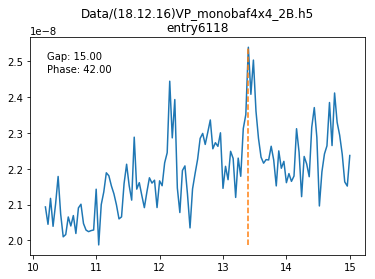

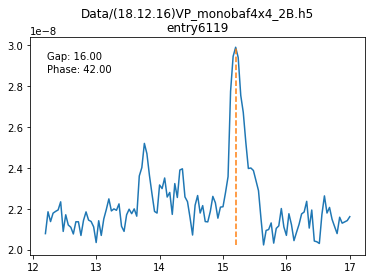

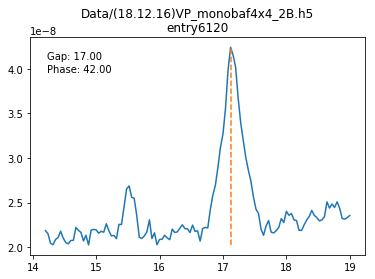

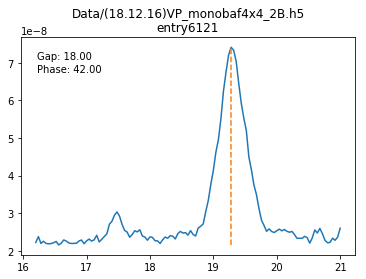

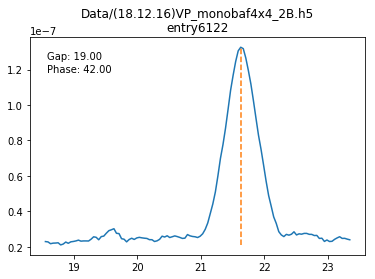

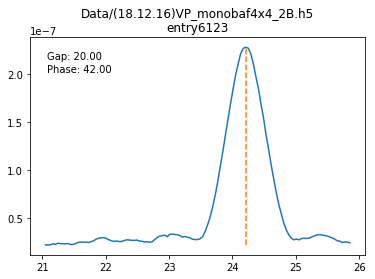

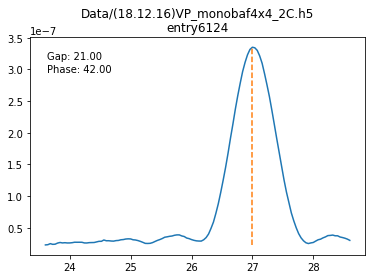

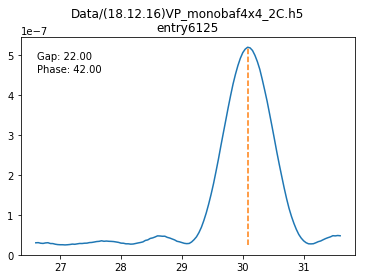

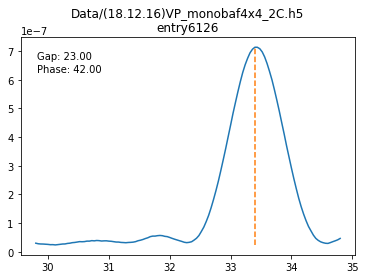

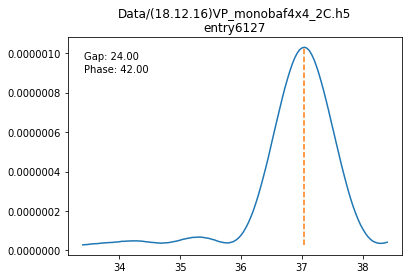

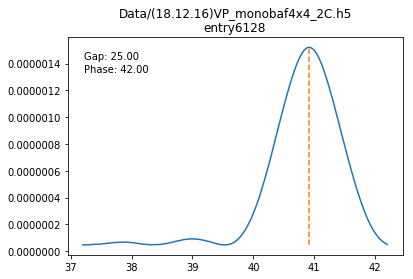

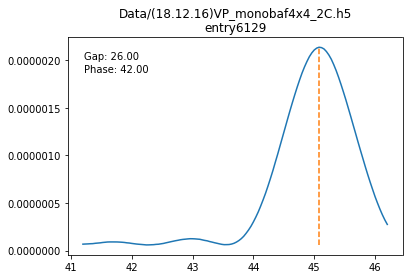

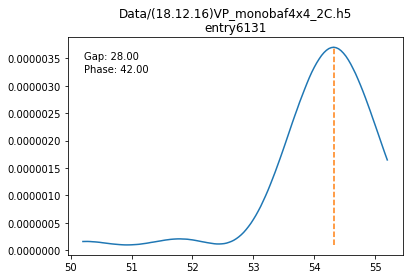

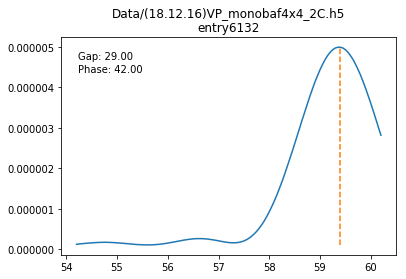

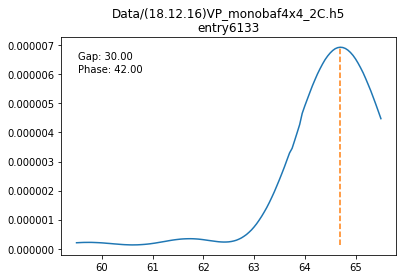

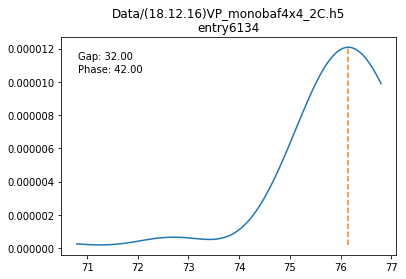

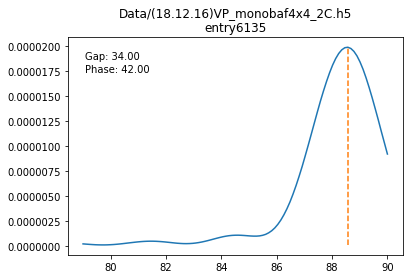

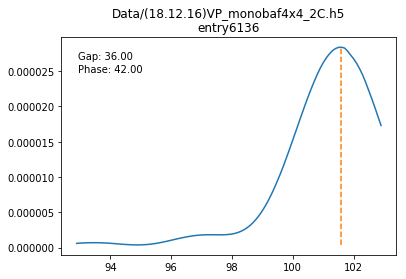

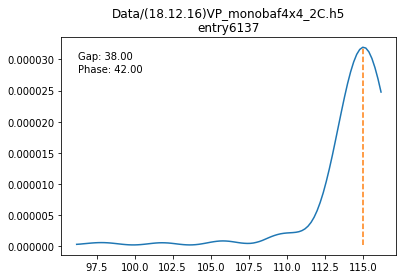

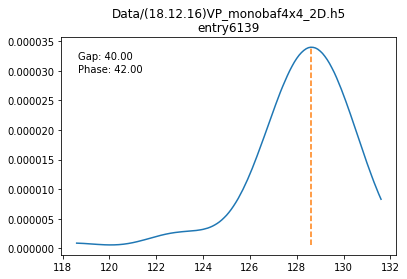

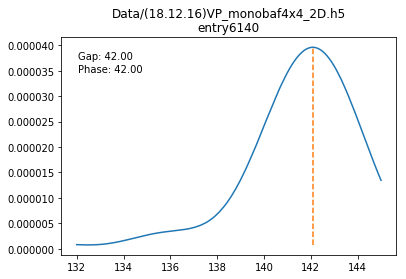

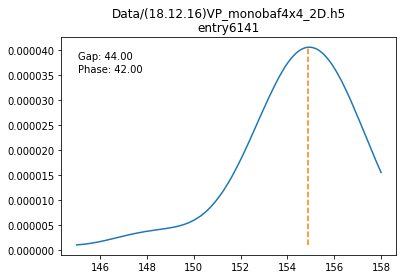

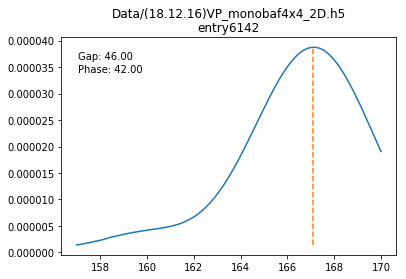

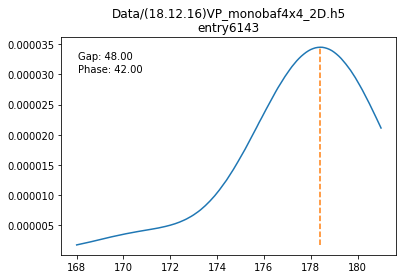

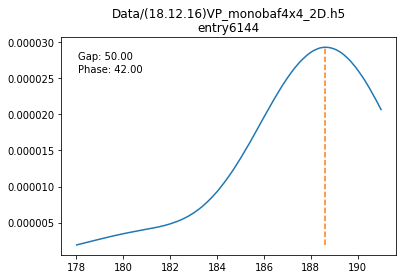

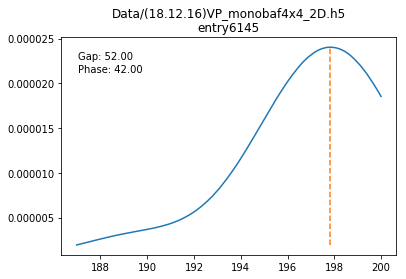

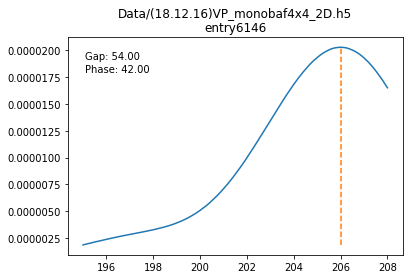

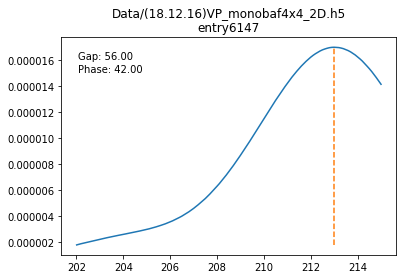

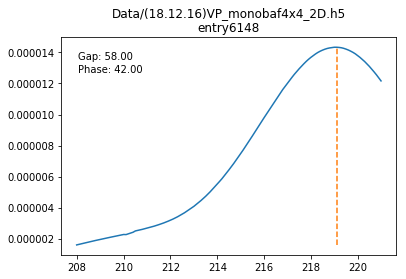

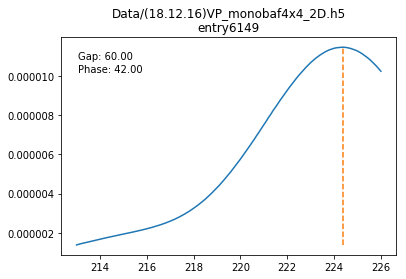

In [36]:
hv=[]
gap=[]
flux=[]

for element in scansToLoad:
    fileName = element[0]
    scanIndex = element[1]
    scan = HDF5loadscan(fileName,scanIndex)
    scan['diodeCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em02_ch03']]
    plt.plot(scan['mono_energy'],scan['diodeCurrent'])
    plt.title("{0}\nentry{1}".format(fileName,scanIndex))
    if EPU_info_exists(fileName,scanIndex):
        ax=gca()
        plt.text(0.05,0.9,"Gap: {0:.2f}".format(scan['EPU_R1_110_GAPposition'][-1]),transform=ax.transAxes)
        plt.text(0.05,0.84,"Phase: {0:.2f}".format(scan['EPU_R1_110_PHASEposition'][-1]),transform=ax.transAxes)       
    current_max=max(scan['diodeCurrent'])
    current_min=min(scan['diodeCurrent'])
    current_max_index=scan['diodeCurrent'].index(current_max)
    hv_max=scan['mono_energy'][current_max_index]
    if EPU_info_exists(fileName,scanIndex):
        hv.append(hv_max)
        gap.append(scan['EPU_R1_110_GAPposition'][-1])
        flux.append(currentToFlux(current_max,hv_max))
        
    plt.plot([hv_max,hv_max],[current_min,current_max],linestyle='--')
      
    plt.show()

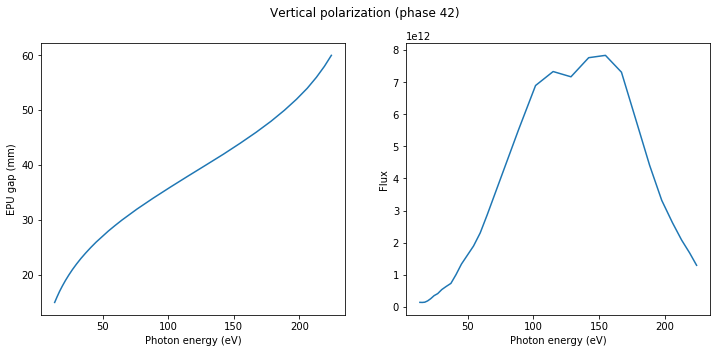

In [37]:
fig=plt.figure(figsize=(12,5))
plt.suptitle("Vertical polarization (phase 42)")
plt.subplot(1,2,1)
plt.plot(hv,gap)
plt.xlabel("Photon energy (eV)")
plt.ylabel("EPU gap (mm)")

plt.subplot(1,2,2)
plt.plot(hv,flux)
plt.xlabel("Photon energy (eV)")
plt.ylabel("Flux")
plt.show()

In [46]:
now = datetime.datetime.now()

f=open("vpol_gap_table.txt",'w')

f.write("Table generated ")
f.write(now.strftime("%Y-%m-%d %H:%M"))
f.write("\nEPU gap (mm)\tFundamental position (eV)\n")
for index,element in enumerate(gap):
    f.write("{0:.2f}\t{1:.2f}\n".format(gap[index],hv[index]))
f.close()